In [9]:
import sys
! /usr/bin/python3 -m pip install nltk datasets transformers torch pandas matplotlib seaborn scikit-learn tqdm wordcloud ipywidgets shap optuna seaborn

Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 KB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 KB 19.7 MB/s eta 0:00:00
  Using cached optuna-3.5.0-py3-none-any.whl (413 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
  Using cached alembic-1.13.1-py3-none-any.whl (233 kB)
  Using cached colorlog-6.8.2-py3-none-any.whl (11 kB)


In [30]:
! /usr/bin/python3 -m pip install --upgrade Pillow

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 10.7 MB/s eta 0:00:0000:010:01


In [10]:
!jupyter nbextension install --user --py widgetsnbextension
!jupyter nbextension enable --user --py widgetsnbextension

Installing /home/porat/.local/lib/python3.10/site-packages/widgetsnbextension/static -> jupyter-js-widgets
Up to date: /home/porat/.local/share/jupyter/nbextensions/jupyter-js-widgets/extension.js.LICENSE.txt
Up to date: /home/porat/.local/share/jupyter/nbextensions/jupyter-js-widgets/extension.js.map
Up to date: /home/porat/.local/share/jupyter/nbextensions/jupyter-js-widgets/extension.js
- Validating: OK

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable widgetsnbextension --user --py
    
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Fake News Detection

 In this notebook, we will use the `GonzaloA/fake_news` dataset to train a model to detect fake news. We will use the `transformers` library to fine-tune a BERT model on this task. We will also use the `optuna` library to perform hyperparameter optimization.  

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import torch
from torch.utils.data import Dataset
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import numpy as np
import optuna

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words

[nltk_data] Downloading package punkt to /home/porat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/porat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

# Load  and prepare the dataset
 We will use the `load_dataset` function from the `datasets` library to load the `GonzaloA/fake_news` dataset. We will then split the dataset into training, validation, and test sets. We will also clean the text by removing stopwords we discovered that the dataset contains a lot of stopwords, so we will remove them to reduce the noise in the data. 
  Since Bert can only handle sequences of up to 512 tokens, we will split the texts into chunks of 512 tokens. We will then tokenize the chunks using the BERT tokenizer.

In [3]:
full_dataset = load_dataset('GonzaloA/fake_news')

/home/porat/.local/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [4]:
# remove unnamed column
full_dataset['train'] = full_dataset['train'].remove_columns('Unnamed: 0')
full_dataset['validation'] = full_dataset['validation'].remove_columns('Unnamed: 0')
full_dataset['test'] = full_dataset['test'].remove_columns('Unnamed: 0')

In [5]:
full_dataset['train'].info.features

{'title': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [6]:
train_df = pd.DataFrame(full_dataset['train'])
val_df = pd.DataFrame(full_dataset['validation'])
test_df = pd.DataFrame(full_dataset['test'])
# Check for missing values
print("Missing values in train dataset:\n", train_df.isnull().sum())
print("Missing values in validation dataset:\n", val_df.isnull().sum())
print("Missing values in test dataset:\n", test_df.isnull().sum())
# Check for duplicates
print("Duplicates in train dataset:\n", train_df.duplicated().sum())
print("Duplicates in validation dataset:\n", val_df.duplicated().sum())
print("Duplicates in test dataset:\n", test_df.duplicated().sum())

Missing values in train dataset:
 title    0
text     0
label    0
dtype: int64
Missing values in validation dataset:
 title    0
text     0
label    0
dtype: int64
Missing values in test dataset:
 title    0
text     0
label    0
dtype: int64
Duplicates in train dataset:
 0
Duplicates in validation dataset:
 0
Duplicates in test dataset:
 0


In [7]:
model_name = "distilroberta-base"  # bert-base-uncased
tokenizer = AutoTokenizer.from_pretrained(model_name)
special_tokens = ['[TITLE]', '[TEXT]']
num_added_toks = tokenizer.add_tokens(special_tokens, special_tokens=True)
print('[TITLE] token id: ', tokenizer.convert_tokens_to_ids('[TITLE]'))
print('[TEXT] token id: ', tokenizer.convert_tokens_to_ids('[TEXT]'))


[TITLE] token id:  50265
[TEXT] token id:  50266


In [8]:


def remove_stopwords(text):
    text = text.lower()
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)


class ChunkedTextDataset(Dataset):
    def __init__(self, titles, texts, labels, chunk_size=512):
        self.inputs = []
        self.attention_masks = []
        self.labels = []

        for title, text, label in zip(titles, texts, labels):
            combined_text = '[TITLE] ' + title + ' [TEXT] ' + text
            tokenized_text = tokenizer(combined_text, max_length=chunk_size, truncation=True,
                                       padding='max_length', return_tensors='pt')
            self.inputs.append(tokenized_text['input_ids'])
            self.attention_masks.append(tokenized_text['attention_mask'])
            self.labels.append(label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx].squeeze(),
            'attention_mask': self.attention_masks[idx].squeeze(),
            'labels': torch.tensor(self.labels[idx])
        }

In [9]:
def load_and_prepare_data(split, seed=42, dataset_percentage=1):
    if split == "train":
        reduced_dataset = full_dataset['train'].shuffle(seed=seed).select(
            range(int(len(full_dataset['train']) * dataset_percentage)))
    else:
        reduced_dataset = full_dataset[split]
    reduced_texts = tqdm([remove_stopwords(text) for text in reduced_dataset["text"]], desc=f'Cleaning {split} texts')
    reduced_labels = reduced_dataset["label"]
    reduced_titles = reduced_dataset["title"]
    return reduced_titles, reduced_texts, reduced_labels

In [10]:
# Load dataset splits
train_titles, train_texts, train_labels = load_and_prepare_data("train")
val_titles, val_texts, val_labels = load_and_prepare_data("validation")
test_titles, test_texts, test_labels = load_and_prepare_data("test")

train_dataset = ChunkedTextDataset(train_titles, train_texts, train_labels)
val_dataset = ChunkedTextDataset(val_titles, val_texts, val_labels)
test_dataset = ChunkedTextDataset(test_titles, test_texts, test_labels)


Cleaning validation texts:   0%|                                                                                                                               | 0/8117 [00:00<?, ?it/s]

Cleaning train texts: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 24352/24353 [01:31<00:00, 266.56it/s]

Cleaning validation texts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 8116/8117 [01:27<00:00, 92.38it/s]


Cleaning test texts:   0%|                                                                                                                         | 1/8117 [01:06<150:47:15, 66.88s/it]

Cleaning test texts:   1%|▋                                                                                                                         | 47/8117 [01:06<2:15:08,  1.00s/it]

Cleaning test texts:   1%|█▍                                         

# Exploratory Data Analysis

 data exploration is an important step in any machine learning project. It allows us to understand the data and identify any issues that need to be addressed. In this section, we will explore the `GonzaloA/fake_news` dataset and perform some basic analysis to gain insights into the data.
 
 we first visualize the distribution of the labels in the training, validation, and test sets. We then create a word cloud to visualize the most common words in the dataset. We also plot the top 10 most common words in the dataset. Finally, we visualize the top 20 bigrams and trigrams in the dataset, annotated with the counts for each class (fake and real).
 .

In [ ]:
# Create a word cloud
def generate_word_cloud(texts):
    combined_text = " ".join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(
        combined_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


# Show word cloud
generate_word_cloud(train_texts)

In [11]:
def plot_top_words(data, n=10):
    counter = Counter(" ".join(data).split())
    most_common = counter.most_common(n)
    most_common_words = [word for word, freq in most_common]
    frequencies = [freq for word, freq in most_common]

    plt.figure(figsize=(15, 5))
    sns.barplot(x=most_common_words, y=frequencies)
    plt.title('Top 10 most common words')
    plt.show()

In [12]:
def clean_text_for_visualization(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))
    text = text.translate(str.maketrans('', '', "“”‘’—"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(filtered_text)

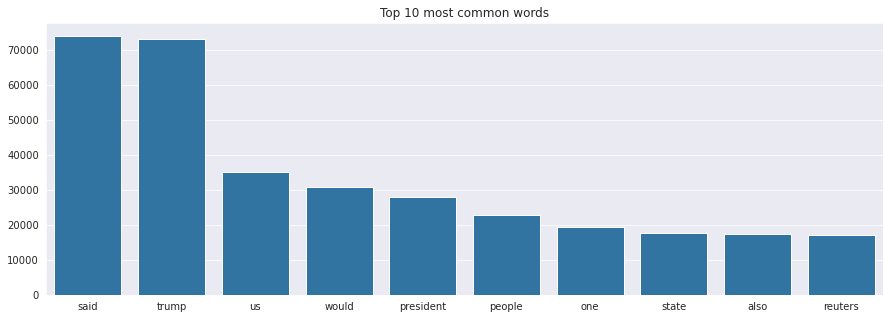

In [13]:
cleaned_texts_for_visualization = [clean_text_for_visualization(text) for text in train_texts]
plot_top_words(cleaned_texts_for_visualization)

In [14]:
def plot_annotated_ngrams_fixed(texts, labels, n=2, n_terms=20):
    vec = CountVectorizer(ngram_range=(n, n)).fit(texts)
    bag_of_words = vec.transform(texts)
    feature_names = vec.get_feature_names_out()
    sum_words = bag_of_words.sum(axis=0)

    # Calculate the counts for each class
    class_counts = np.zeros((2, len(feature_names)))
    for label, row in zip(labels, bag_of_words):
        class_counts[label] += row.toarray()[0]

    # Aggregate total counts for each n-gram and sort them
    total_counts = sum_words.A1
    indices = np.argsort(-total_counts)
    top_indices = indices[:n_terms]

    # Prepare the data for plotting
    top_ngrams = feature_names[top_indices]
    top_counts = total_counts[top_indices]
    top_fake_counts = class_counts[0, top_indices]
    top_real_counts = class_counts[1, top_indices]

    data = {
        'ngram': top_ngrams,
        'frequency': top_counts,
        'fake_count': top_fake_counts,
        'real_count': top_real_counts
    }
    df = pd.DataFrame(data)

    # Plot
    plt.figure(figsize=(10, 8))
    bars = sns.barplot(x='frequency', y='ngram', hue='ngram', data=df, palette='viridis', legend=False)
    plt.title(f'Top {n}-grams in Dataset')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-grams')

    # Annotate bars with the count of fake and real labels
    for i, bar in enumerate(bars.patches):
        plt.text(
            bar.get_width(),
            bar.get_y() + bar.get_height() / 2,
            f'Fake: {int(df.iloc[i]["fake_count"])}, Real: {int(df.iloc[i]["real_count"])}',
            va='center'
        )

    plt.show()

In [16]:
plot_annotated_ngrams_fixed(train_texts, train_labels, n=2, n_terms=20)

KeyboardInterrupt: 

# Model Training

 We will use the `transformers` library to fine-tune a BERT model on the fake news detection task. We will use the `Trainer` class to handle the training loop and the `TrainingArguments` class to define the training configuration. We will also define a function to compute the evaluation metrics for the task. We will use the `precision`, `recall`, and `F1 score` as the evaluation metrics. We will then use the `optuna` library to perform hyperparameter optimization to find the best hyperparameters for the model.

In [11]:
# check for cuda
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU


In [12]:
def compute_metrics(eval_pred):
    eval_predictions, eval_labels = eval_pred
    eval_predictions = np.argmax(eval_predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(eval_labels, eval_predictions, average='binary')
    acc = accuracy_score(eval_labels, eval_predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [38]:
def objective(trial):
    # Define hyperparameters for the trial
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)
    num_train_epochs = trial.suggest_int("num_train_epochs", 1, 5)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32])
    warmup_steps = trial.suggest_int("warmup_steps", 0, 500)

    # Create the model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, device_map=device)
    # Define the training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_train_epochs,
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        warmup_steps=warmup_steps,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        disable_tqdm=False,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
    )

    # Create the trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    metrics = trainer.evaluate()

    # Return the metric to be optimized
    return metrics['eval_f1']

In [39]:
# Create the study and run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(f"Best trial: {study.best_trial.number}")
print(f"Best value (F1 score): {study.best_value}")
print(f"Best hyperparameters: {study.best_params}")

[I 2024-02-13 18:50:32,375] A new study created in memory with name: no-name-342cecc5-ac91-445f-937f-4172e6d27c52
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


Checkpoint destination directory ./results\checkpoint-609 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-1218 already exists and is non-empty.Saving will proceed but saved results may be invalid.


[I 2024-02-13 22:09:59,349] Trial 0 finished with value: 0.9702156795617939 and parameters: {'learning_rate': 2.142824278123738e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'warmup_steps': 42}. Best is trial 0 with value: 0.9702156795617939.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


[I 2024-02-13 23:32:10,303] Trial 1 finished with value: 0.9678820436621328 and parameters: {'learning_rate': 4.1010951065515624e-05, 'num_train_epochs': 1, 'per_device_train_batch_size': 32, 'warmup_steps': 401}. Best is trial 0 with value: 0.9702156795617939.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


[I 2024-02-14 03:07:59,093] Trial 2 finished with value: 0.9676099556767814 and parameters: {'learning_rate': 1.3657461684292952e-06, 'num_train_epochs': 4, 'per_device_train_batch_size': 8, 'warmup_steps': 465}. Best is trial 0 with value: 0.9702156795617939.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


Checkpoint destination directory ./results\checkpoint-77 already exists and is non-empty.Saving will proceed but saved results may be invalid.


[I 2024-02-14 04:33:27,656] Trial 3 finished with value: 0.9753727971079982 and parameters: {'learning_rate': 6.355343327602066e-05, 'num_train_epochs': 1, 'per_device_train_batch_size': 32, 'warmup_steps': 219}. Best is trial 3 with value: 0.9753727971079982.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


Checkpoint destination directory ./results\checkpoint-305 already exists and is non-empty.Saving will proceed but saved results may be invalid.


[I 2024-02-14 05:46:29,582] Trial 4 finished with value: 0.9480374665477252 and parameters: {'learning_rate': 2.064649831052212e-06, 'num_train_epochs': 1, 'per_device_train_batch_size': 8, 'warmup_steps': 261}. Best is trial 3 with value: 0.9753727971079982.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


Checkpoint destination directory ./results\checkpoint-305 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-610 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-915 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-1220 already exists and is non-empty.Saving will proceed but saved results may be invalid.


[I 2024-02-14 10:09:00,443] Trial 5 finished with value: 0.9820730866467479 and parameters: {'learning_rate': 2.191598408839492e-06, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'warmup_steps': 167}. Best is trial 5 with value: 0.9820730866467479.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


Checkpoint destination directory ./results\checkpoint-77 already exists and is non-empty.Saving will proceed but saved results may be invalid.


[I 2024-02-14 11:35:28,150] Trial 6 finished with value: 0.8788920129126314 and parameters: {'learning_rate': 4.718101048666568e-06, 'num_train_epochs': 1, 'per_device_train_batch_size': 32, 'warmup_steps': 363}. Best is trial 5 with value: 0.9820730866467479.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


Checkpoint destination directory ./results\checkpoint-305 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-610 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-915 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-1220 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-1525 already exists and is non-empty.Saving will proceed but saved results may be invalid.


[I 2024-02-14 16:02:39,828] Trial 7 finished with value: 0.9825887743413516 and parameters: {'learning_rate': 1.2580246392963075e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'warmup_steps': 356}. Best is trial 7 with value: 0.9825887743413516.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


Checkpoint destination directory ./results\checkpoint-77 already exists and is non-empty.Saving will proceed but saved results may be invalid.


[I 2024-02-14 20:07:25,233] Trial 8 finished with value: 0.9702496295451954 and parameters: {'learning_rate': 2.096683306604786e-06, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'warmup_steps': 342}. Best is trial 7 with value: 0.9825887743413516.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


Checkpoint destination directory ./results\checkpoint-305 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-610 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-915 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-1220 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-1525 already exists and is non-empty.Saving will proceed but saved results may be invalid.


[I 2024-02-15 02:07:07,327] Trial 9 finished with value: 0.980747192298877 and parameters: {'learning_rate': 6.778688081449428e-06, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'warmup_steps': 318}. Best is trial 7 with value: 0.9825887743413516.


Best trial: 7
Best value (F1 score): 0.9825887743413516
Best hyperparameters: {'learning_rate': 1.2580246392963075e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'warmup_steps': 356}


In [13]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, device_map=device)
model.resize_token_embeddings(len(tokenizer))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(50267, 768)

In [14]:
learning_rate = 1.2580246392963075e-05
num_train_epochs = 5
per_device_train_batch_size = 8
warmup_steps = 356

training_args = TrainingArguments(
    output_dir='./API/results',
    logging_dir='./API/logs',
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5,
    lr_scheduler_type="linear",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    disable_tqdm=False,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Training
history = trainer.train()

wandb: Currently logged in as: chen24201 (api-project). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


Checkpoint destination directory ./API/results/checkpoint-3045 already exists and is non-empty.Saving will proceed but saved results may be invalid.


# Model Evaluation

 We will evaluate the trained model on the test set. We will use the `evaluate` method of the `Trainer` class to compute the evaluation metrics on the test set. We will also use the `predict` method to generate predictions on the test set and compute the confusion matrix to visualize the model's performance.

In [ ]:
# Evaluation on the test set
results = trainer.evaluate(test_dataset)
print(results)

In [ ]:

predictions, labels, _ = trainer.predict(test_dataset)
predictions = predictions.argmax(axis=-1)

# Generate the confusion matrix
cm = confusion_matrix(labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Conclusion

 In this notebook, we used the `transformers` library to fine-tune a BERT model on the fake news detection task. We used the `optuna` library to perform hyperparameter optimization to find the best hyperparameters for the model. We then evaluated the trained model on the test set and visualized its performance using a confusion matrix. The model achieved an accuracy of 0.98 on the test set, demonstrating its effectiveness in detecting fake news.

In [49]:
model_path = "./model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('model\\tokenizer_config.json',
 'model\\special_tokens_map.json',
 'model\\vocab.txt',
 'model\\added_tokens.json',
 'model\\tokenizer.json')